In [2]:
import numpy as np
import scipy.special as special
import scipy.integrate as integrate

import matplotlib.pyplot as plt
import time
import mpmath

In [3]:
import sys
sys.path.append('../../bat_beamshapes/')

import beamshapes

In [4]:
def absorption(f, t=20, rh=60):
    """ In dB/m
    
        f: frequency in Hz
        t: temperature in °C
        rh: relative humidity in %
        ps: atmospheric pressure in Pa

        From http://en.wikibooks.org/wiki/Engineering_Acoustics/Outdoor_Sound_Propagation
        See __main__ for actual curves.
    """

    ## 1 atm in Pa
    ps = 1.01325e5
    ps0 = 1.01325e5
    
    if type(f) != int and type(f)!=float and type(f)!=np.float64:
        f = f.reshape(1, len(f))
    if type(t) != int:
        t = t.reshape(len(t), 1)
    if type(rh) != int:
        rh = rh.reshape(len(rh), 1)
    T = t + 273.15
    T0 = 293.15
    T01 = 273.16

    Csat = -6.8346 * np.power(T01 / T, 1.261) + 4.6151
    rhosat = np.power(10, Csat)
    H = rhosat * rh * ps0 / ps

    frn = (ps / ps0) * np.power(T0 / T, 0.5) * (
            9 + 280 * H * np.exp(-4.17 * (np.power(T0 / T, 1/3.) - 1)))

    fro = (ps / ps0) * (24.0 + 4.04e4 * H * (0.02 + H) / (0.391 + H))

    alpha = f * f * (
        1.84e-11 / ( np.power(T0 / T, 0.5) * ps / ps0 )
        + np.power(T / T0, -2.5)
        * (
            0.10680 * np.exp(-3352 / T) * frn / (f * f + frn * frn)
            + 0.01278 * np.exp(-2239.1 / T) * fro / (f * f + fro * fro)
            )
        )

    return 20 * alpha / np.log(10)

In [5]:
def get_plot_settings(x, y):
    plt.xticks(np.linspace(0, x.shape[1]-1, 5), 
            np.round(x[0,np.linspace(0, x.shape[1]-1, 5).astype(int)], 1), fontsize=16)
    plt.yticks(np.linspace(0, y.shape[0]-1, 5), 
            np.round(y[np.linspace(0, y.shape[0]-1, 5).astype(int),0], 1), fontsize=16)
    plt.xlabel('X Distance from Point', fontsize=16)
    plt.ylabel('Y Distance from Point', fontsize=16)
    plt.grid(which='both')
    plt.colorbar()

In [22]:
j = 1j
medium_density = 1204 # in g / m^3
speed_in_medium = 343 # m / s
a = 0.003
bat_SPL_in_dB = 110

Bat Frequency 30000.0


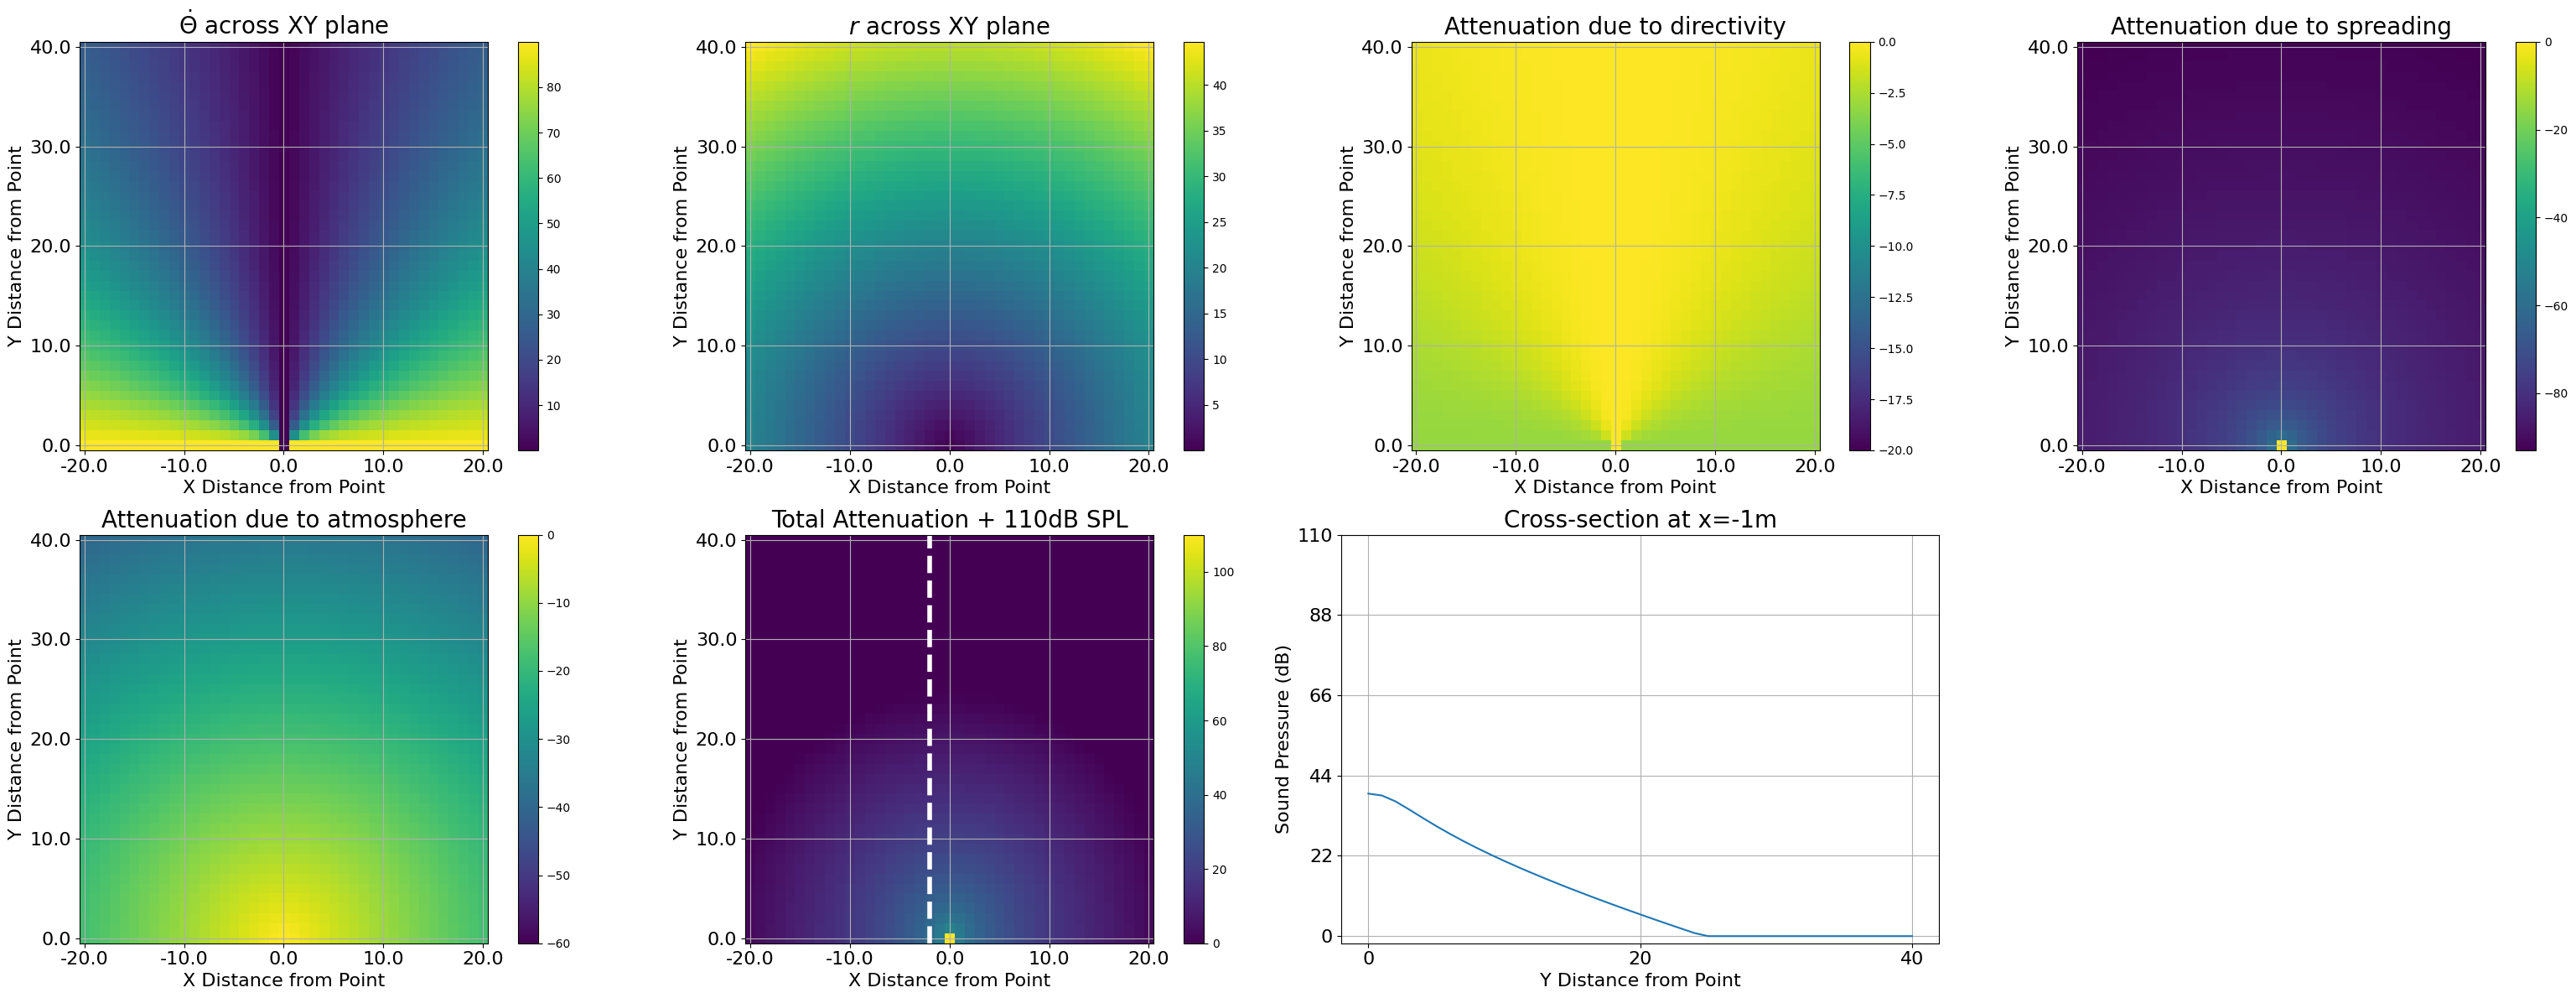

Bat Frequency 40000.0


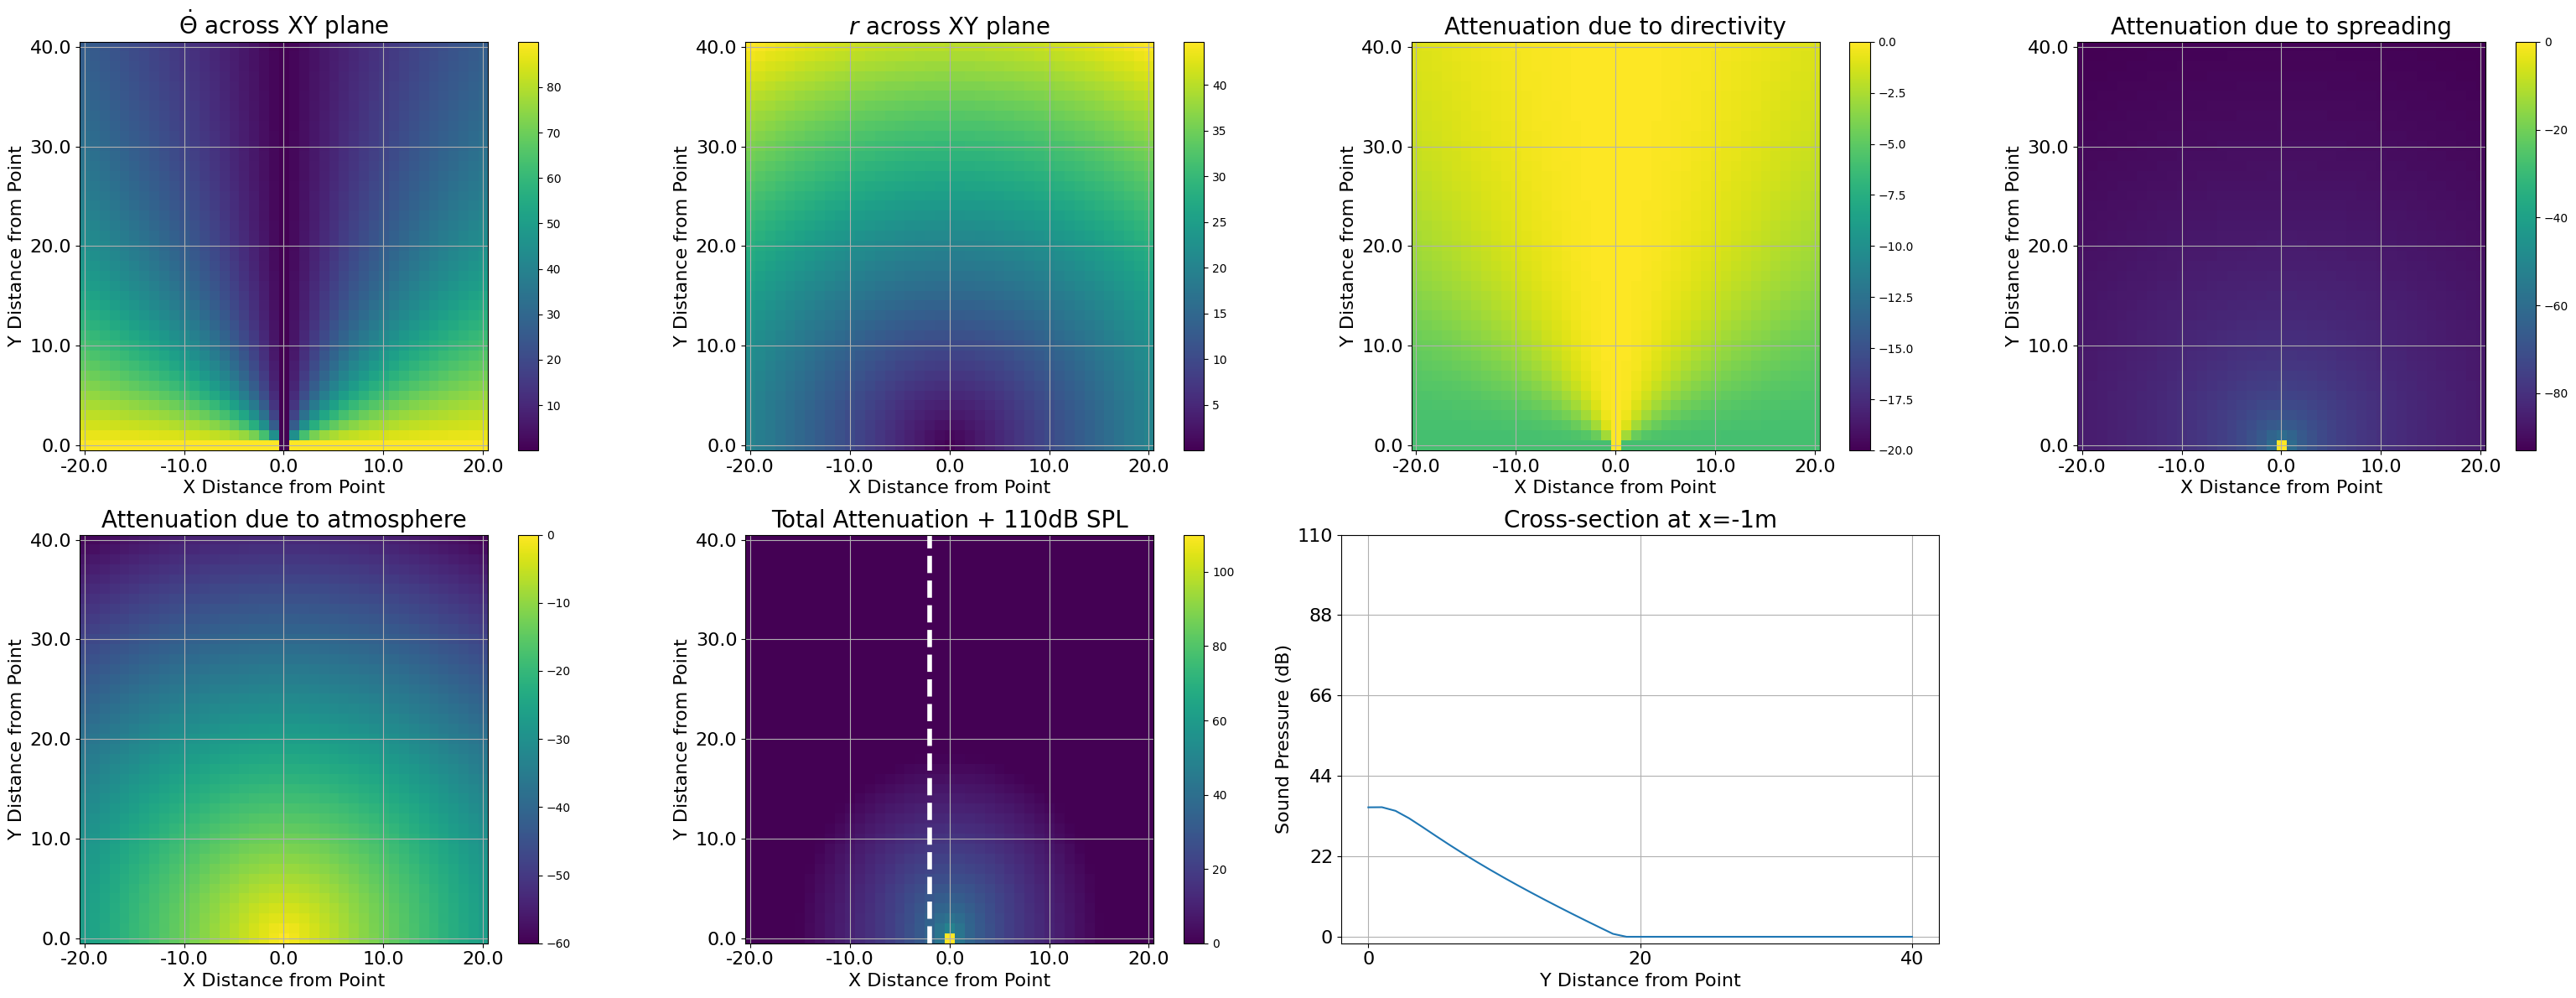

Bat Frequency 50000.0


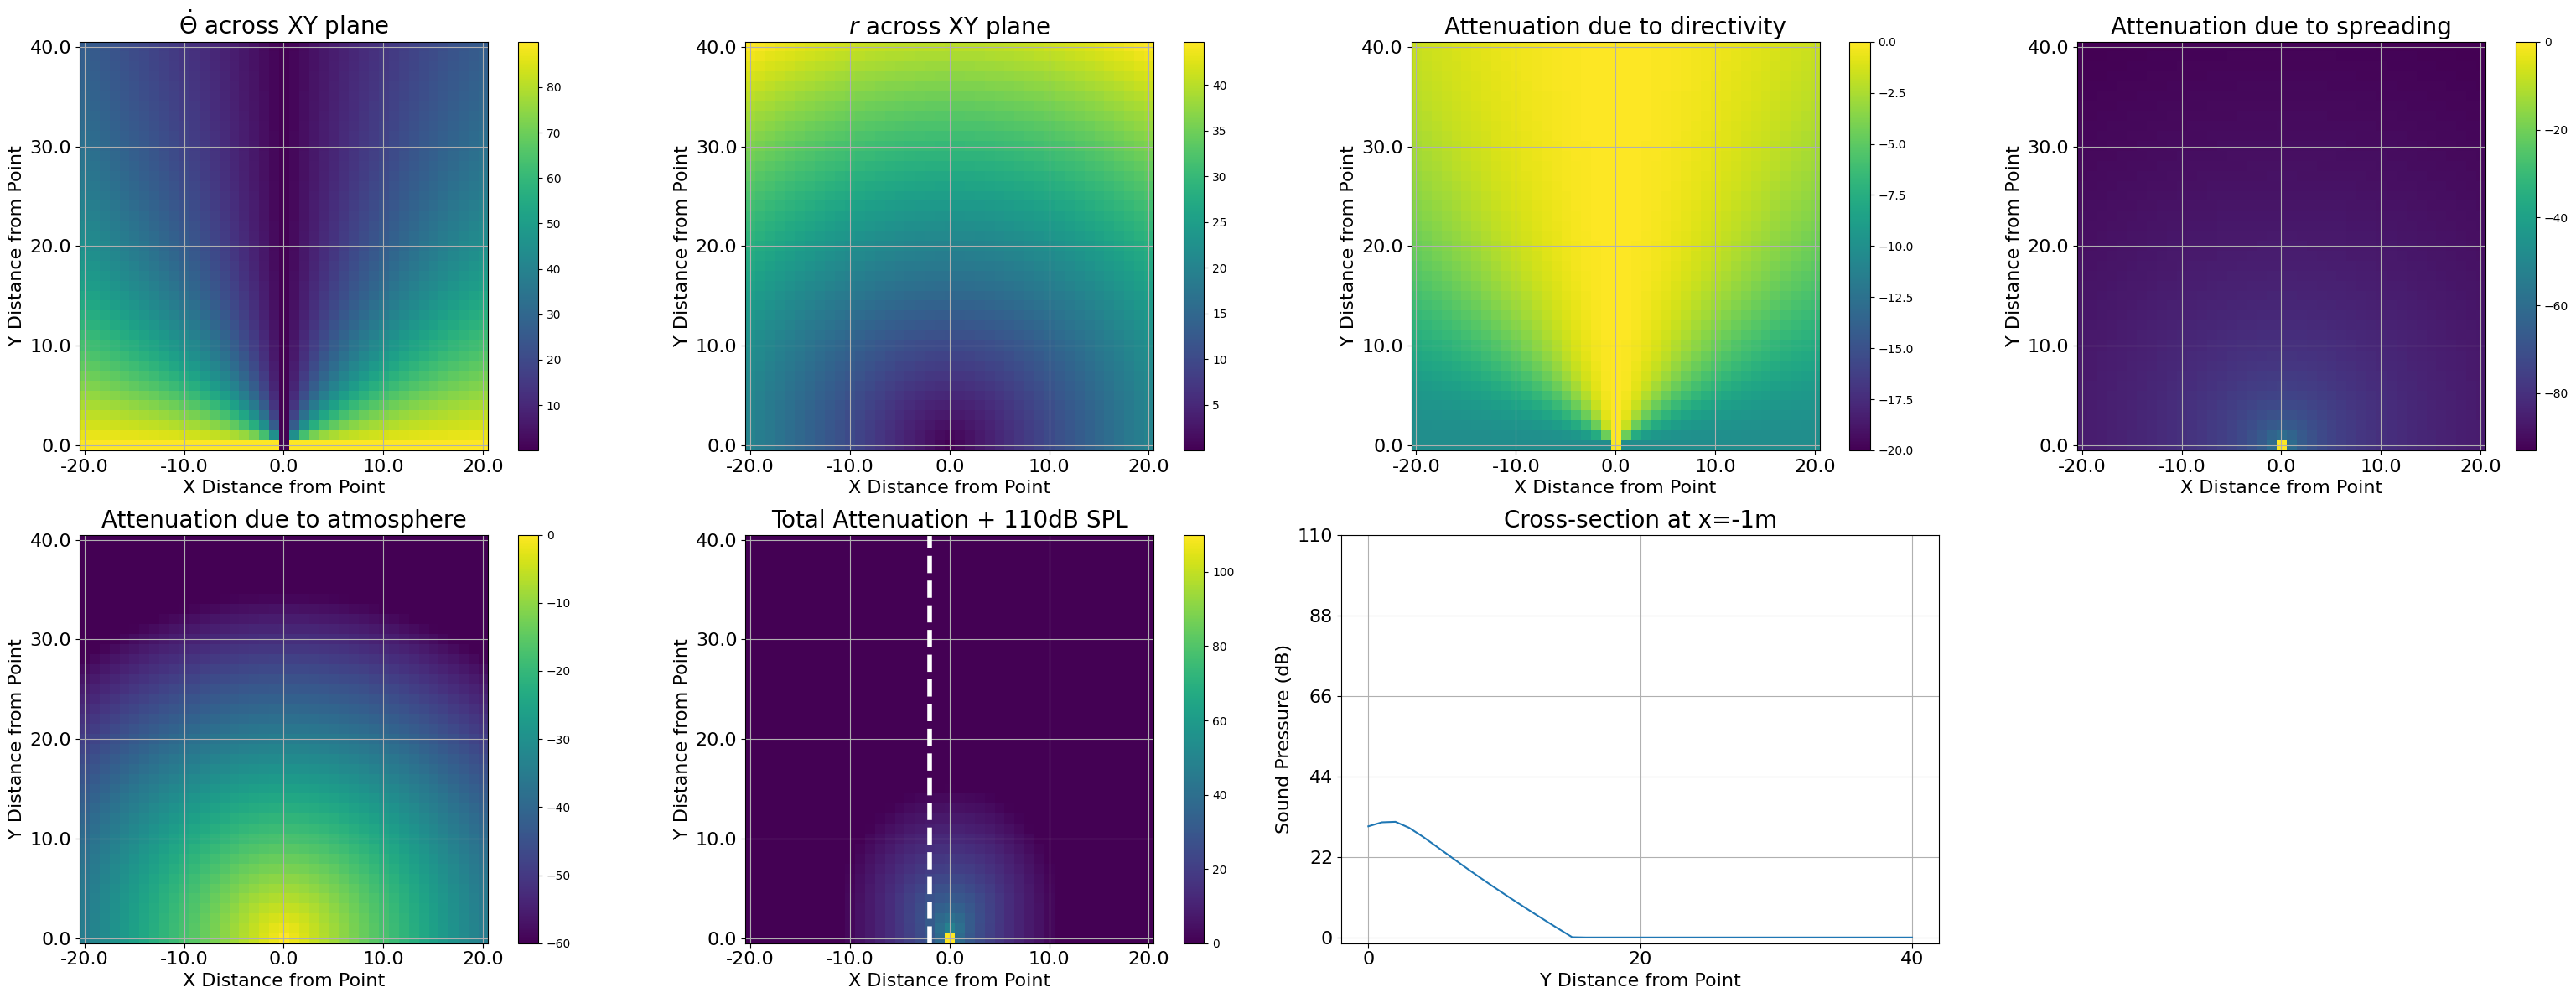

Bat Frequency 60000.0


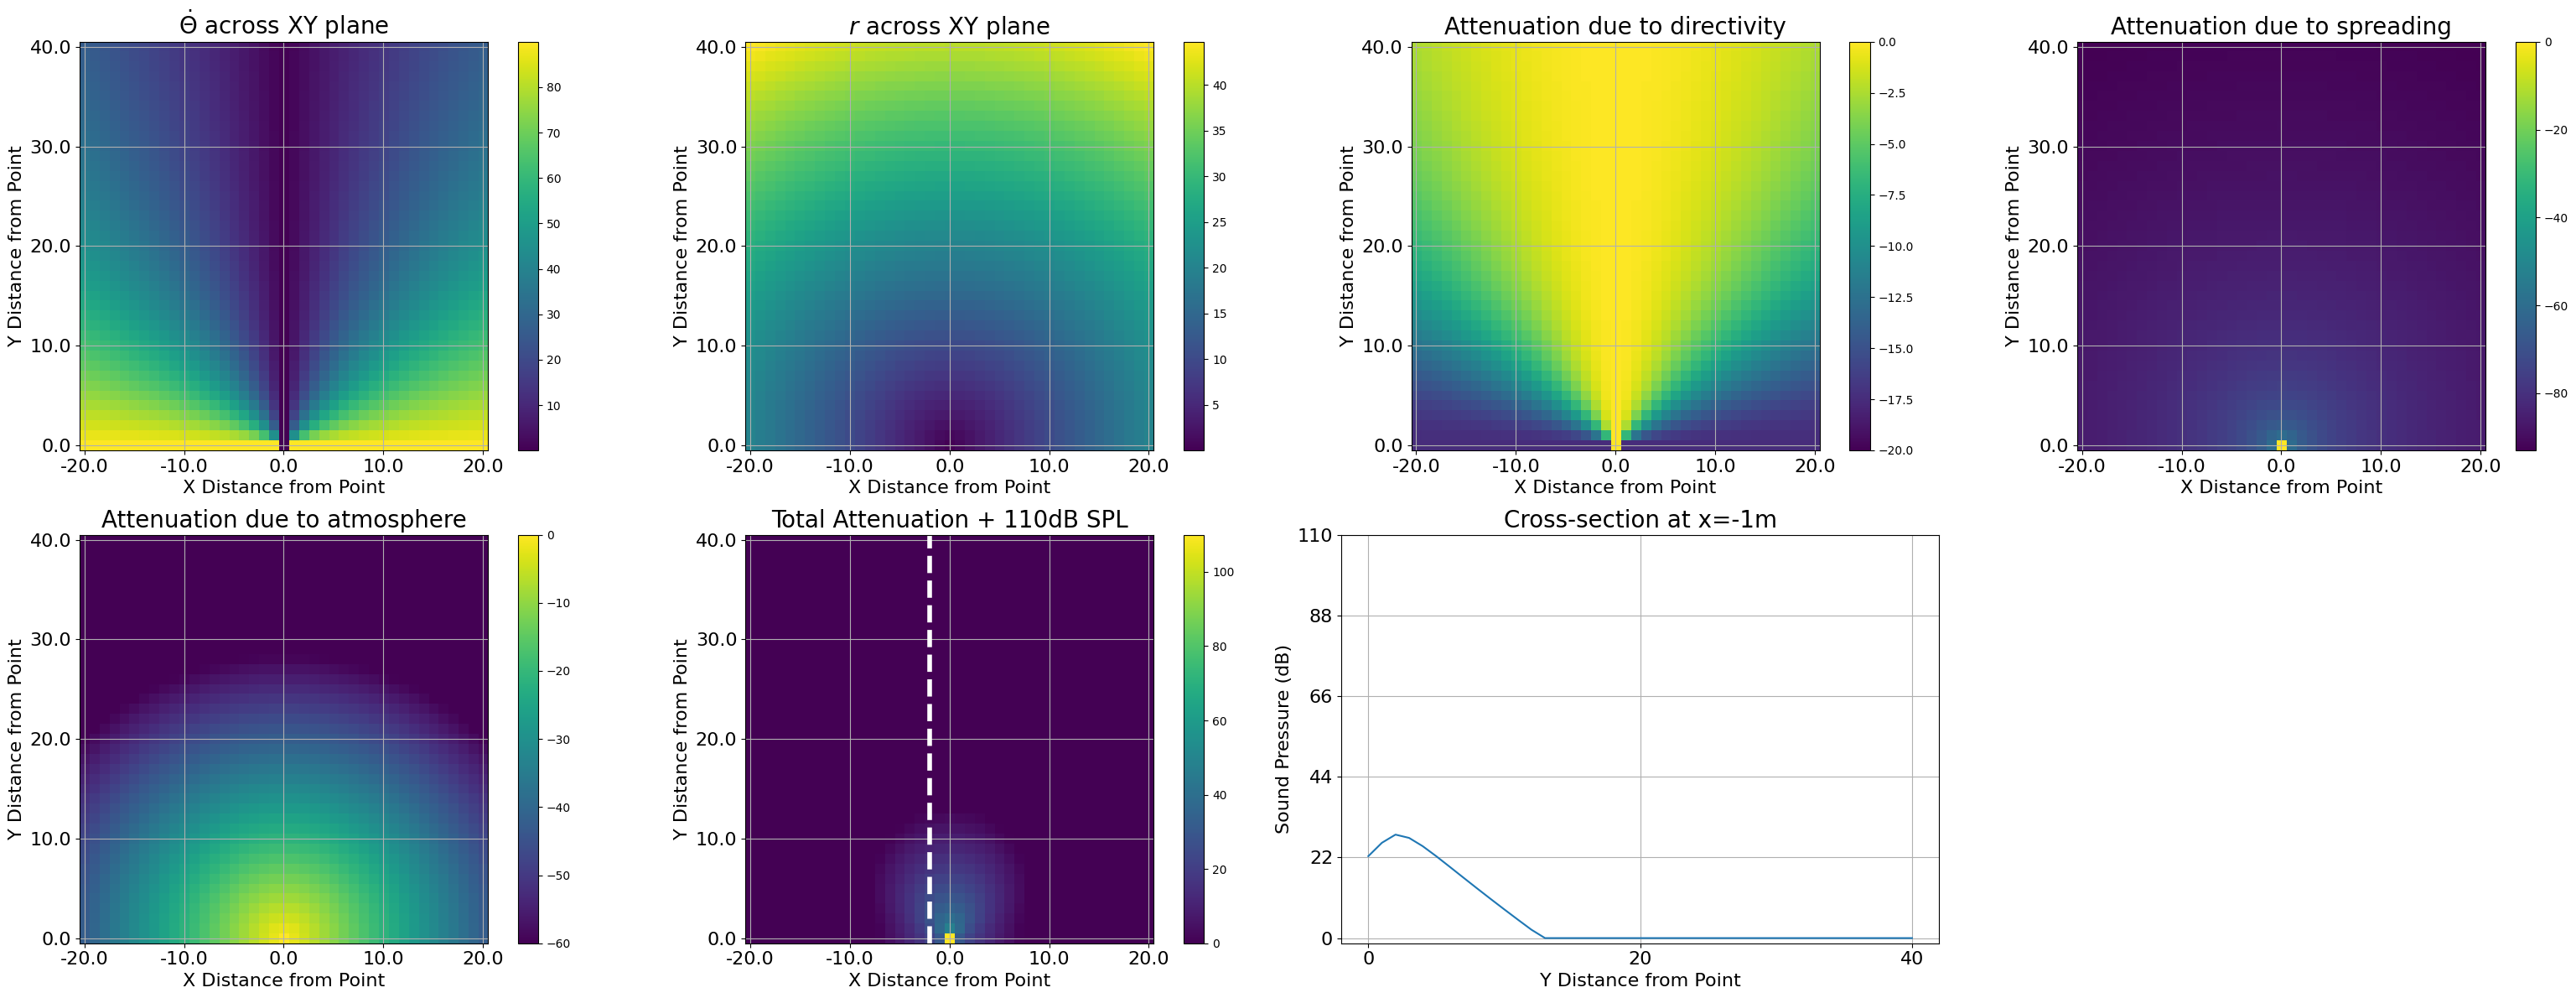

Bat Frequency 70000.0


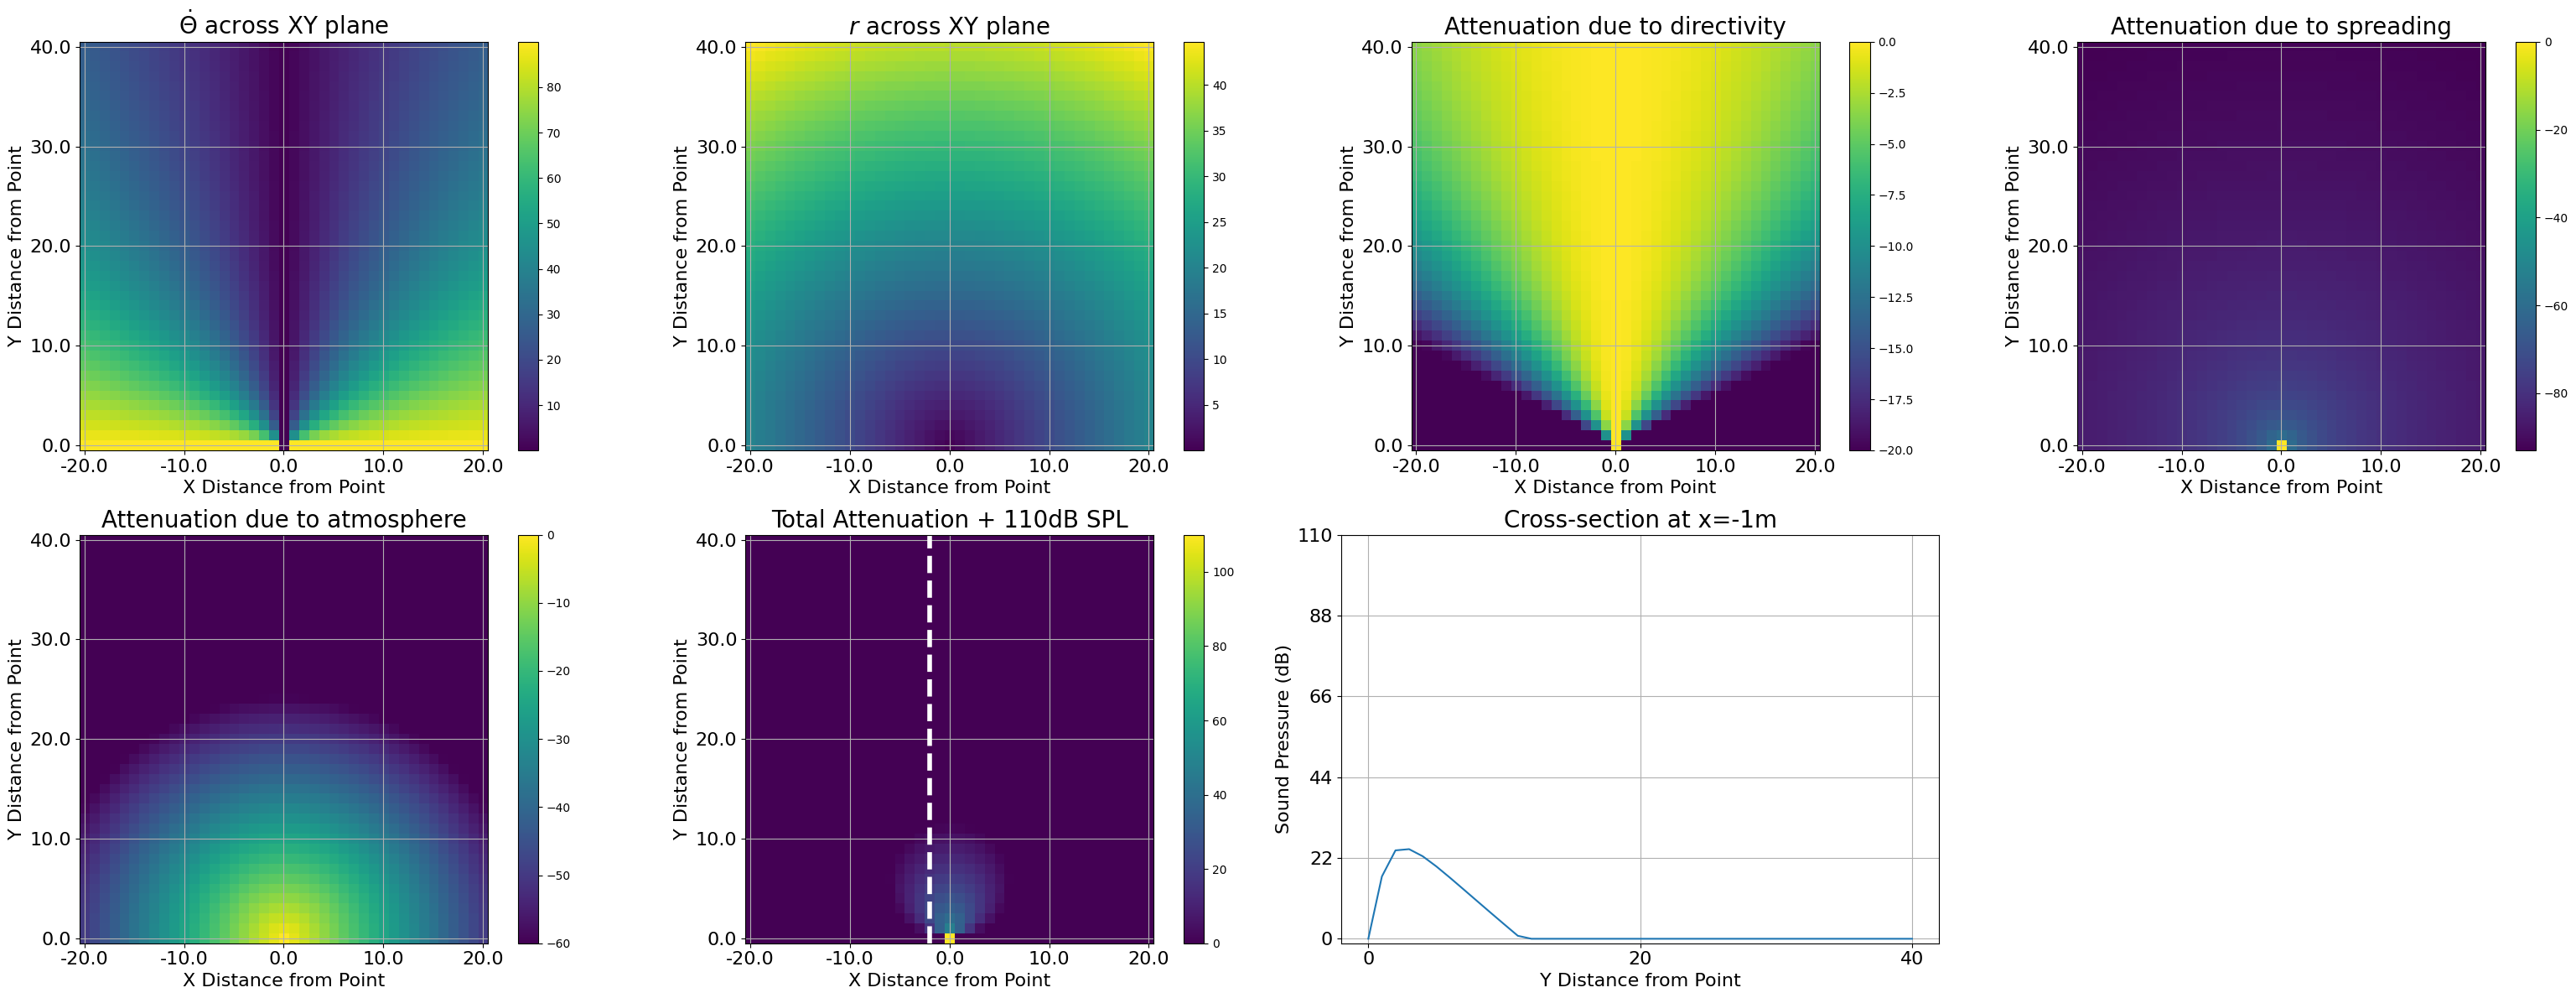

Bat Frequency 80000.0


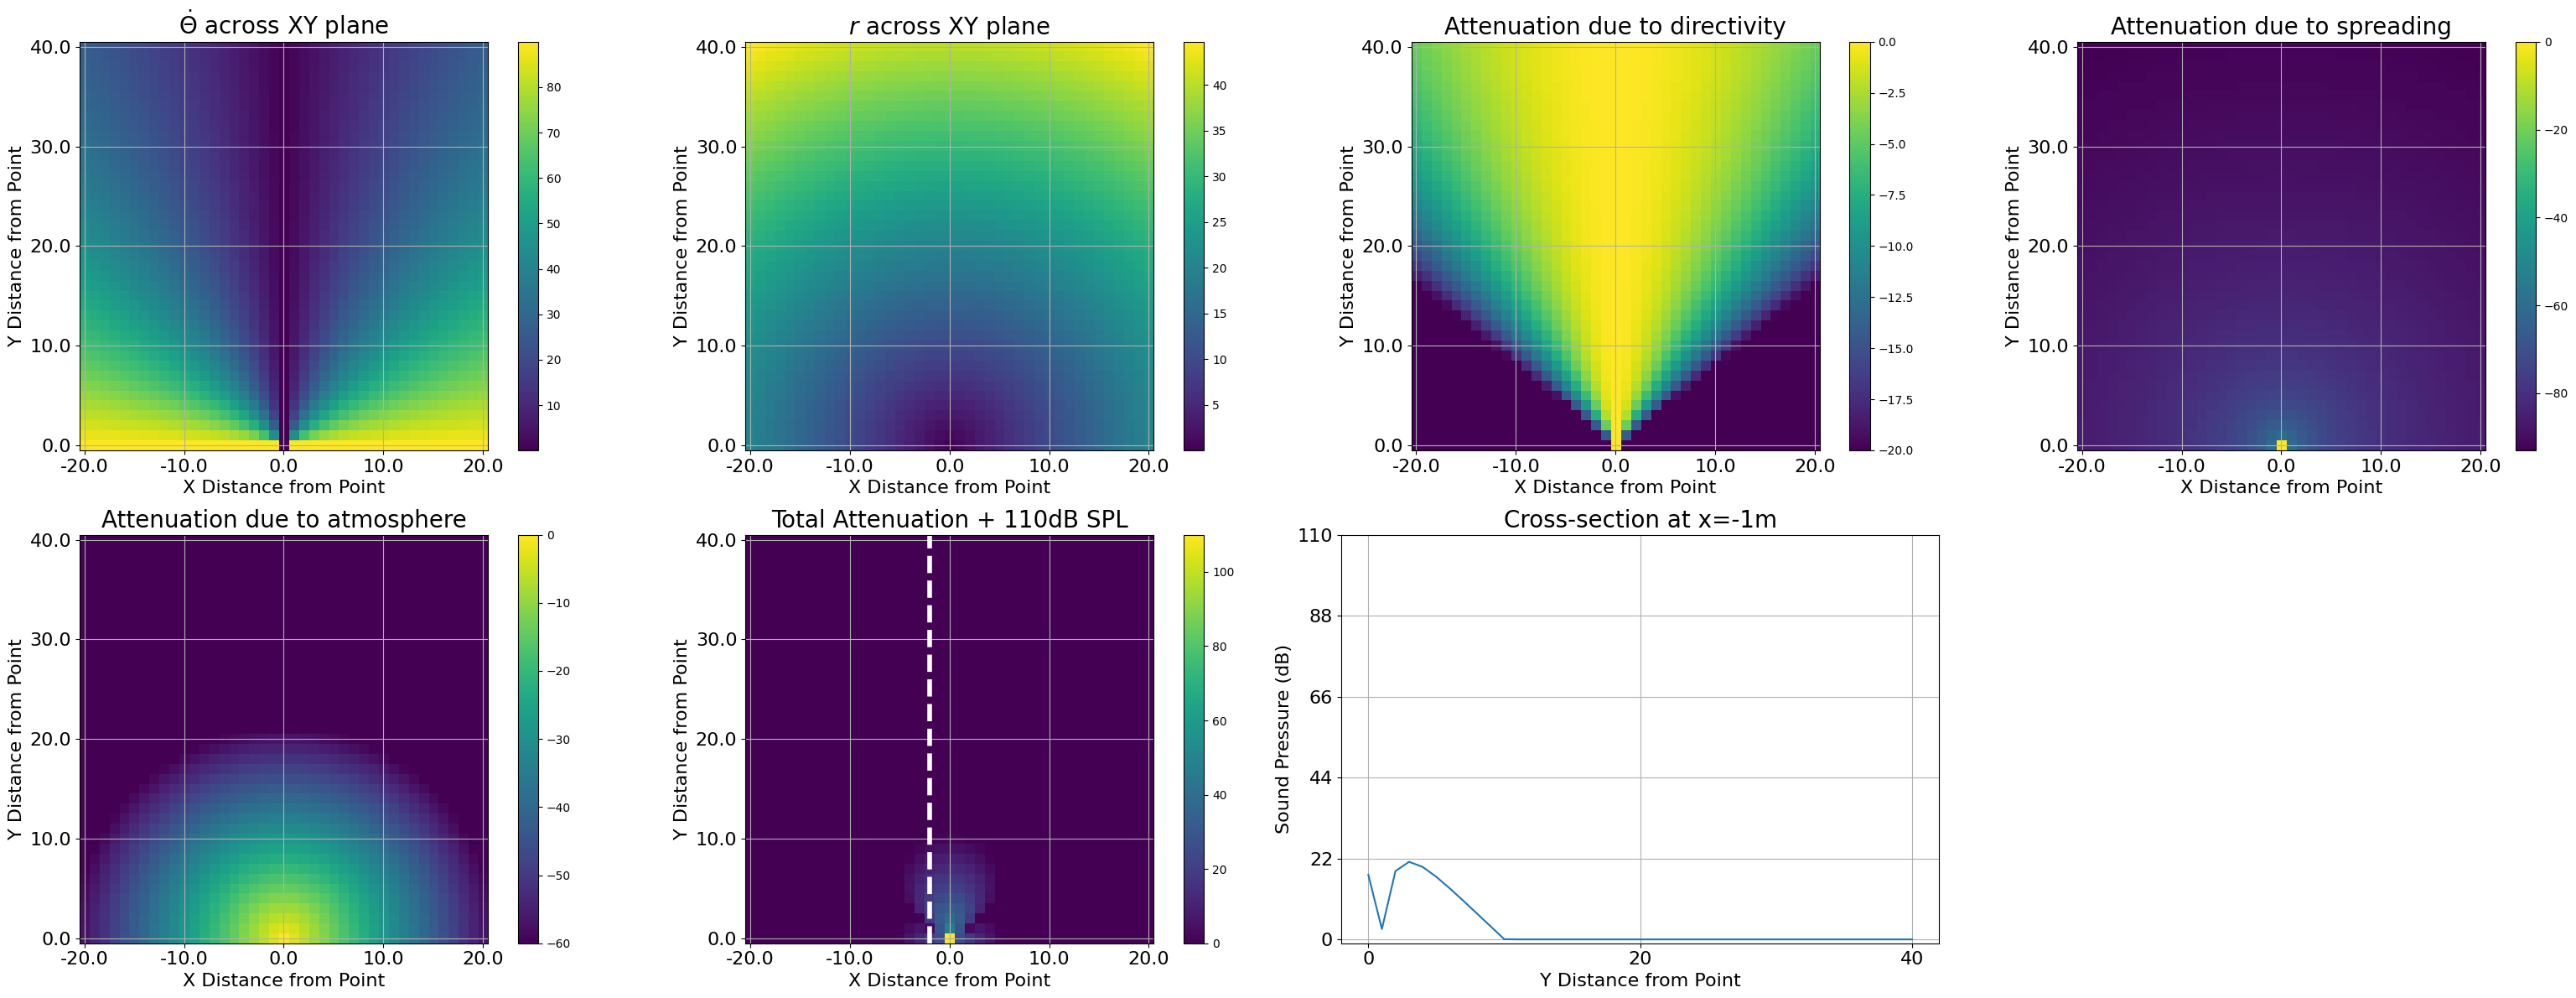

Bat Frequency 90000.0


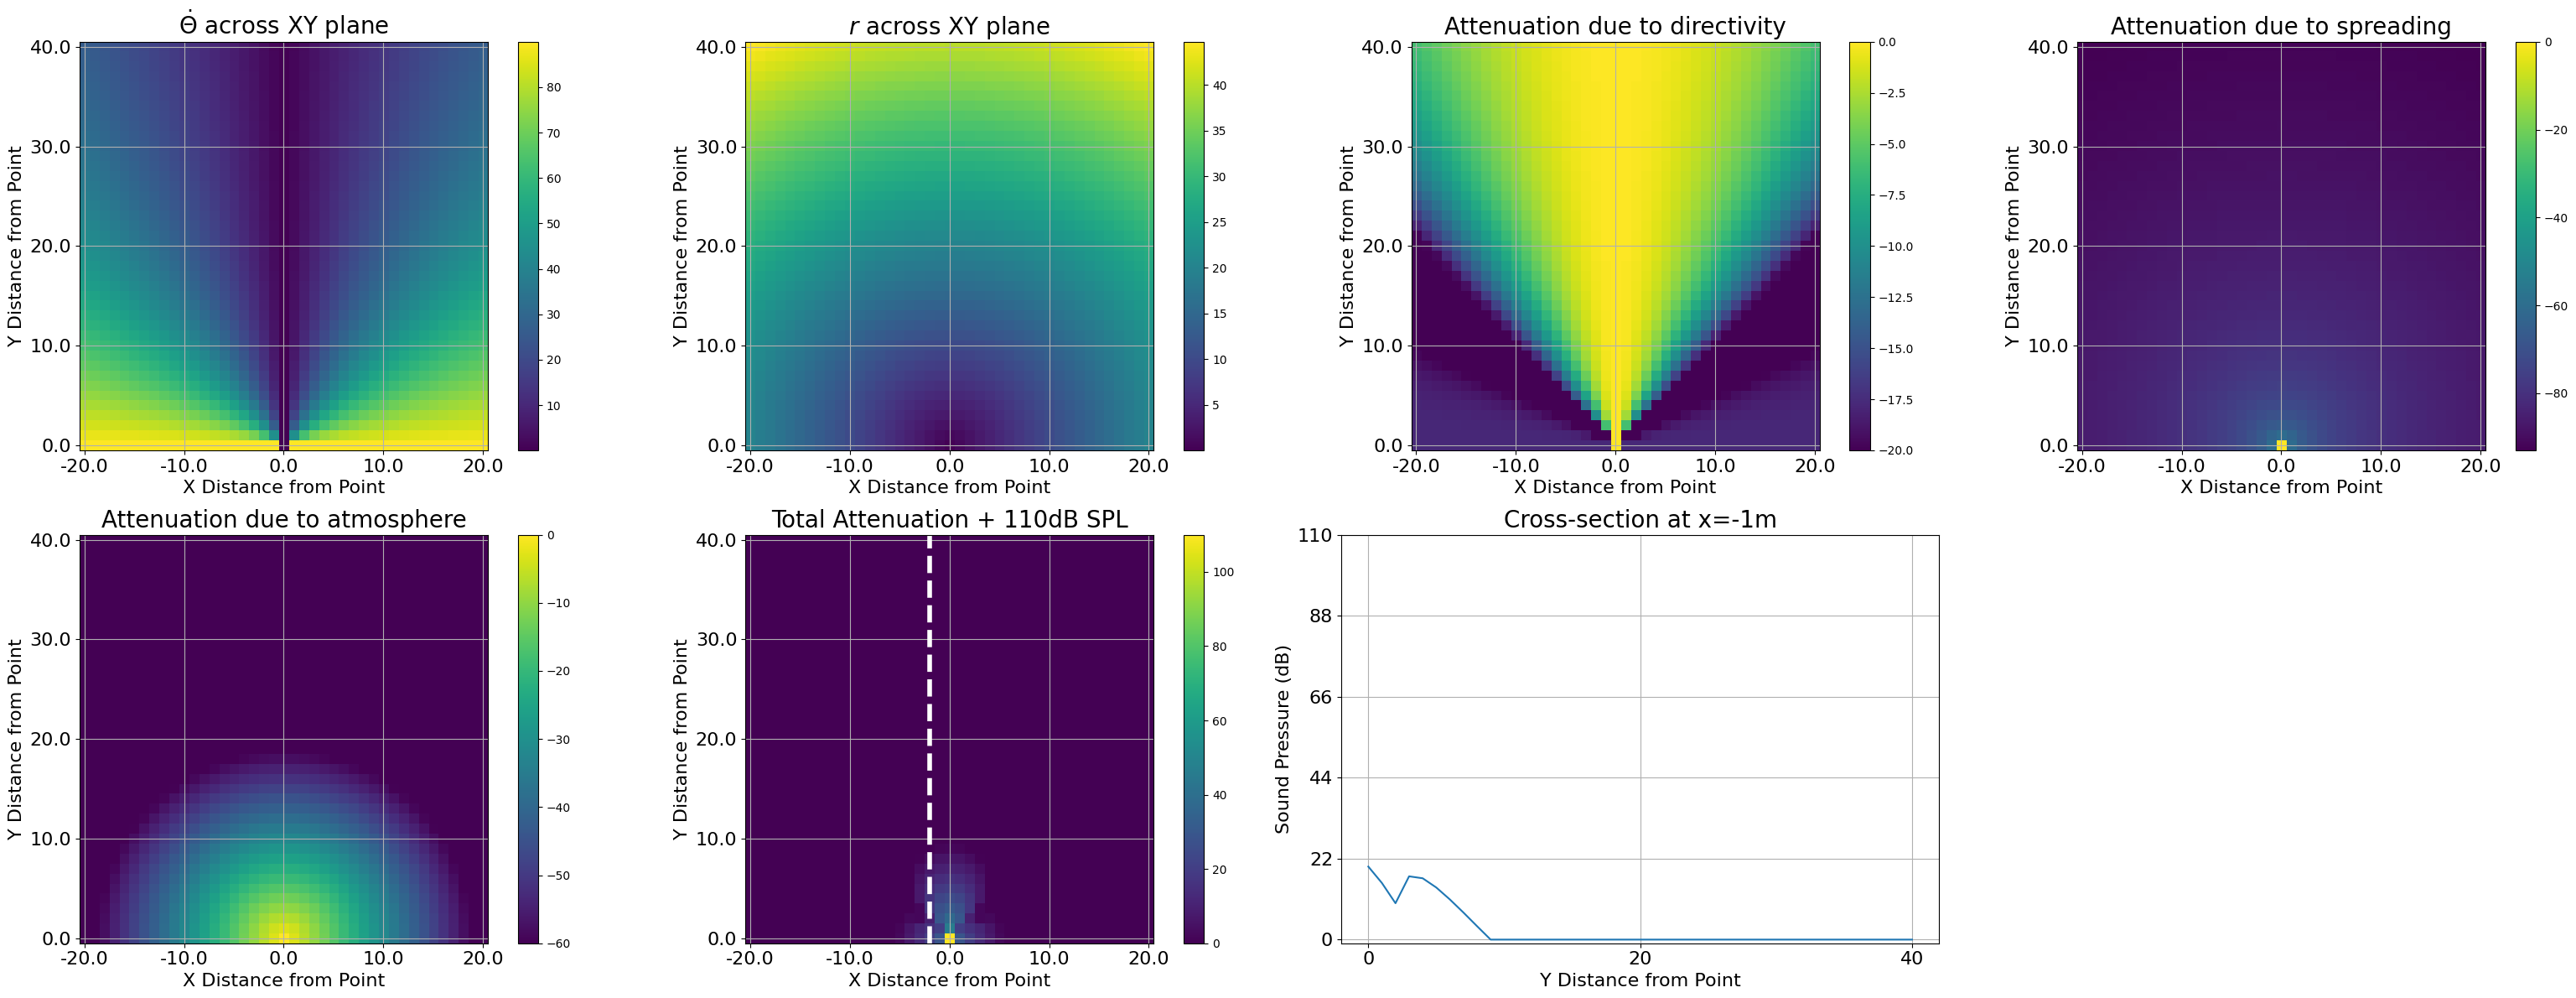

In [24]:
for bat_frequency in np.arange(30e3, 100e3, 10e3):
    print(f'Bat Frequency {bat_frequency}')
    wavelength = speed_in_medium / bat_frequency

    k = 2*np.pi/wavelength
    ka = k*a
    medium = medium_density * speed_in_medium

    bat_flight_speed = 1.0 # m/s 
    step = bat_flight_speed
    x = np.arange(-20, 20+step, step)
    x = x.reshape(1, x.shape[0])

    y_step = -bat_flight_speed
    y = np.arange(40, 0+y_step, y_step)
    y = y.reshape(y.shape[0], 1)
    y_inds = np.where(np.isclose(y,0, atol=1e-4))
    y[y_inds] = 1e-3
    z = 0

    r = np.sqrt((x**2) + (y**2))
    theta = np.arctan(x/y)
    t_inds = np.where(np.isclose(theta,0, atol=1e-4))
    theta[t_inds] = 1e-3

    phase_term = np.exp(-j*k*r)
    spreading = j*k*(a**2)*(medium)*phase_term/(2*r)
    spreading_dB = 20*np.log10(np.abs(spreading/np.max(spreading)))
    spreading_dB = np.clip(spreading_dB, None, 0)

    atmospheric_coeff = absorption(bat_frequency)
    absorption_dB = -atmospheric_coeff*r

    D_theta = 2*special.j1(ka*np.sin(theta))/(ka*np.sin(theta))
    D_theta_dB = 20*np.log10(np.abs(D_theta/np.max(D_theta)))
    # D_theta_dB[D_theta_dB==D_theta_dB.min().min()] = -120

    p_dB = spreading_dB+D_theta_dB+bat_SPL_in_dB+absorption_dB

    plt.figure(figsize=(32, 12))
    plt.subplot(241)
    plt.title(r"$\dot{\Theta}$ across XY plane", fontsize=20)
    plt.imshow(np.abs(theta*(180/np.pi)))
    get_plot_settings(x, y)

    plt.subplot(242)
    plt.title(r"$r$ across XY plane", fontsize=20)
    plt.imshow(np.abs(r))
    get_plot_settings(x, y)

    plt.subplot(243)
    plt.title("Attenuation due to directivity", fontsize=20)
    clipped_D_theta_dB = np.clip(D_theta_dB, -20, None)
    plt.imshow(clipped_D_theta_dB, vmin=-20, vmax=0)
    get_plot_settings(x, y)

    plt.subplot(244)
    plt.title("Attenuation due to spreading", fontsize=20)
    clipped_spreading_dB = np.clip(spreading_dB, -60, None)
    plt.imshow(spreading_dB)
    get_plot_settings(x, y)

    plt.subplot(245)
    plt.title("Attenuation due to atmosphere", fontsize=20)
    clipped_absorption_dB = np.clip(absorption_dB, -60, None)
    plt.imshow(clipped_absorption_dB, vmin=-60, vmax=0)
    get_plot_settings(x, y)

    desired_x_loc = -1
    x_inds = np.where(np.isclose(x,desired_x_loc, atol=step))[1][0]
    plt.subplot(246)
    plt.title("Total Attenuation + 110dB SPL", fontsize=20)
    clip_low = 0
    clip_high = 110
    clipped_p_dB = np.clip(p_dB, clip_low, clip_high)
    plt.imshow(clipped_p_dB, vmin=clip_low, vmax=clip_high)
    plt.axvline(x=x_inds, linestyle='dashed', color='w', linewidth=4)
    get_plot_settings(x, y)

    plt.subplot(247)
    plt.title(f'Cross-section at x={desired_x_loc}m', fontsize=20)
    plt.plot(y, clipped_p_dB[:,x_inds])
    plt.grid(which='both')
    ampls = np.linspace(clip_low, clip_high, 6)
    plt.yticks(ampls, fontsize=16)
    plt.xticks(np.arange(0, y[0,0]+20, 20), fontsize=16)
    plt.xlabel('Y Distance from Point', fontsize=16)
    plt.ylabel('Sound Pressure (dB)', fontsize=16)

    plt.tight_layout()
    plt.show()